# Using qucat programmatically

In this example we study a typical circuit QED system consisting of a transmon qubit coupled to a resonator.

The first step is to import the objects we will be needing from qucat.

In [1]:
# Import the circuit builder
from qucat import Network
# Import the circuit components
from qucat import L,J,C,R

import numpy as np

## Building the circuit

Note that the components (``R``, ``L``, ``C``, ``J``) accept node indexes as their two 
first arguments, 
here we will use the node ``0`` to designate ground. The last arguments should be 
a label (``str``) or a value (``float``) or both, the order in which these
arguments are provided are unimportant.

For the moment, we will specify the value of all the components.

**Note: by default the junction is parametrized by its josephson inductance**

In [2]:
cir = Network([
    C(0,1,100e-15), # Add a capacitor between nodes 0 and 1, with a value of 100fF
    J(0,1,8e-9), # Add a josephson junction, the value is given as Josephson inductance 
    C(1,2,1e-15), # Add the coupling capacitor
    C(2,0,100e-15), # Add the resonator capacitor
    L(2,0,10e-9), # Add the resonator inductor
    R(2,0,1e6) # Add the resonator resistor
])

This implements the following circuit, where we have also indexed the nodes, and we have fixed the value of $L_J$ to ``8e-9`` H

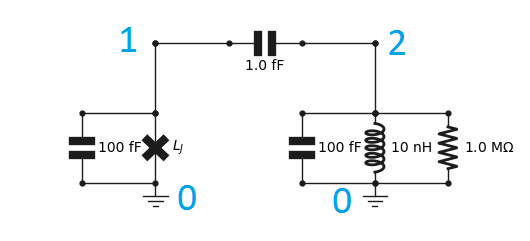

In [3]:
from IPython.display import Image
Image("graphics/transmon_LC_programmatically_1.png")

We now calculate the eigenfrequency, loss-rates, anharmonicity, and Kerr parameters of the circuit. 

This can be done through the functions ``eigenfrequencies``, ``loss_rates``, ``anharmonicities`` and ``kerr``, which return the specified quantities for each mode, **ordered with increasing mode frequency**

## Calculating circuit parameters

### Eigen-frequencies

In [4]:
cir.eigenfrequencies()

array([5.00696407e+09, 5.60042136e+09])

This will return a list of the normal modes of the circuit, we can see they are seperated in frequency by 600 MHz, but we still do not which corresponds to the transmon, and which to the resonator.

To distinquish the two, we can calculate the anharmonicities of each mode.

### Anharmonicity

In [5]:
cir.anharmonicities()

array([5.82661131e+02, 1.91131050e+08])

The first (lowest frequency) mode, has a very small anharmonicity, whilst the second, has an anharmonicity of 191 MHz. The highest frequency mode thus corresponds to the transmon.

### Cross-Kerr or dispersive shift

In this regime of far detuning in frequency, the two modes will interact through a cross-Kerr or dispersive shift, which quantifies the amount by which one mode will shift if frequency if the other is populated with a photon.

We can access this by calculating the Kerr parameters ``K``. In this two dimensional array, the components ``K[i,j]`` correspond to the cross-Kerr interaction of mode ``i`` with mode ``j``. 

In [6]:
K = cir.kerr()
print("%.2f kHz"%(K[0,1]/1e3))

667.43 kHz


From the above, we have found that the cross-Kerr interaction between these two modes is of about 670 kHz.

This should correspond to $2\sqrt{A_0A_1}$ where $A_i$ is the anharmonicity of mode $i$. Let's check that:

In [7]:
A = cir.anharmonicities()
print("%.2f kHz"%(2*np.sqrt(A[0]*A[1])/1e3))

667.43 kHz


### Loss rates

In the studied circuit, the only resistor is located in the resonator. In this regime of large frequency, detuning, we would thus expect the resonator to be more lossy than the transmon.

In [8]:
cir.loss_rates()

array([786052.42260108,   1920.57996173])

### $T_1$ times

When converting these rates to $T_1$ times, one should not forget the $2\pi$ in the conversion

In [9]:
T_1 = 1/cir.loss_rates()/2/np.pi
print(T_1)

[2.02473701e-07 8.28681681e-05]


All these relevant parameters (frequency, dissipation, anharmonicity and Kerr parameters) can be computed using a single function

In [10]:
cir.f_k_A_chi()

(array([5.00696407e+09, 5.60042136e+09]),
 array([786052.42260108,   1920.57996173]),
 array([5.82661131e+02, 1.91131050e+08]),
 array([[5.82661131e+02, 6.67426802e+05],
        [6.67426802e+05, 1.91131050e+08]]))

Using the option ``pretty_print = True`` a more readable summary can be printed

In [11]:
f,k,A,chi = cir.f_k_A_chi(pretty_print=True)

    mode |  freq.  |  diss.  |  anha.  |
       0 | 5.01 GHz | 786 kHz |  583 Hz |
       1 | 5.6 GHz | 1.92 kHz | 191 MHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
    mode |    0    |    1    |
       0 |  583 Hz |         |
       1 | 667 kHz | 191 MHz |



## Hamiltonian, and further analysis with QuTiP

### Generating a Hamiltonian

The Hamiltonian of the circuit, with the non-linearity of the Josephson junctions
Taylor-expanded, is given by

$\hat{H} = \sum_{m\in\text{modes}} hf_m\hat{a}_m^\dagger\hat{a}_m +\sum_j\sum_{2n\le\text{taylor}}E_j\frac{(-1)^{n+1}}{(2n)!}\left(\frac{\phi_{zpf,m,j}}{\phi_0}(\hat{a}_m^\dagger+\hat{a}_m)\right)^{2n}$

And in its construction, we have the freedom to choose the set of ``modes`` to include, the order of the Taylor expansion of the junction potential ``taylor``, and the number of excitations of each mode to consider.

In [12]:
# Compute hamiltonian (for h=1, so all energies are expressed in frequency units, not angular)
H = cir.hamiltonian(
    modes = [0,1],# Include modes 0 and 1
    taylor = 4,# Taylor the Josephson potential to the power 4
    excitations = [8,10])# Consider 8 excitations in mode 0, 10 for mode 1

# QuTiP method which return the eigenergies of the system
ee = H.eigenenergies()

The first transition of the resonator is

In [13]:
print("%.3f GHz"%((ee[1]-ee[0])/1e9))

5.006 GHz


and of the transmon

In [14]:
print("%.3f GHz"%((ee[2]-ee[0])/1e9))

5.394 GHz


Notice the difference, especially for the transmon, with the corresponding normal-mode frequency calculated above. This is a consequence of the zero-point fluctuations entering the junction and changing the effective transition frequency.

Following first-order perturbation, the shift in transition frequency can be estimated from the anharmonicity $A_1$ and cross-kerr coupling $\chi_{0,1}$ and should be given by $-A_1-\chi_{0,1}/2$. We see below that we get fairly close (7 MHz) from the value obtained from the hamiltonian diagonalization.

In [15]:
f,k,A,K = cir.f_k_A_chi()
print("%.3f GHz"%((f[1]-A[1]-K[0,1]/2)/1e9))

5.409 GHz


### Open-system dynamics

A more elaborate use of QuTiP would be to compute the dynamics (for example with qutip.mesolve). The Hamiltonian and collapse operators to use are

In [16]:
# H is the Hamiltonian
H,a_m_list = cir.hamiltonian(modes = [0,1],taylor = 4,excitations = [5,5], return_ops = True)
# !!! which should be in angular frequencies for time-dependant simulations
H = 2.*np.pi*H

# c_ops are the collapse operators 
# !!! which should be in angular frequencies for time-dependant simulations
k = cir.loss_rates()
c_ops = [np.sqrt(2*np.pi*k[0])*a_m_list[0],np.sqrt(2*np.pi*k[1])*a_m_list[1]]

## Sweeping a parameter

The most computationally expensive part of the 
analysis is performed upon initializing the Network. To avoid doing this, 
we have the option to enter a symbolic value for a component.
    
We will only provide a label ``L_J`` for the junction here, 
and its value should be passed
as a keyword argument in subsequent function calls,
for example ``L_J=1e-9``. 

In [17]:
cir = Network([
    C(0,1,100e-15),
    J(0,1,'L_J'),
    C(1,2,1e-15),
    C(2,0,100e-15),
    L(2,0,10e-9),
    R(2,0,1e6)
])

The implemented circuit, overlayed with the nodes, is:

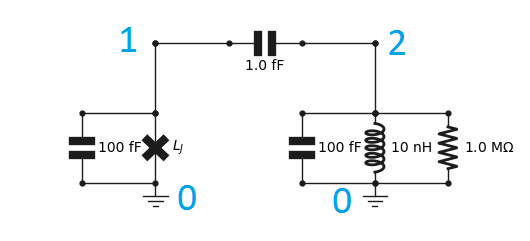

In [18]:
from IPython.display import Image
Image("graphics/transmon_LC_programmatically_1.png")

Since the junction was created without a value, 
we now have to specify it as a keyword argument

In [19]:
import matplotlib.pyplot as plt

C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


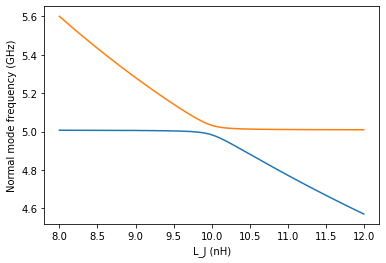

In [24]:
# array of values for the josephson inductance
L_J_list = np.linspace(8e-9,12e-9,1001)

# Eigen-frequencies of the system:
freqs = cir.eigenfrequencies(L_J=L_J_list)

# plot first mode
plt.plot(L_J_list*1e9,freqs[0]/1e9) # plot first mode

# second mode
plt.plot(L_J_list*1e9,freqs[1]/1e9) # plot first mode

# Add plot labels
plt.xlabel('L_J (nH)')
plt.ylabel('Normal mode frequency (GHz)')

# show the figure
plt.show()